In [1]:
import os
import io

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import json

import random
import numpy as np

In [2]:
vocab_size = 10000
embedding_dim = 64
max_length = 200

trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

training_portion = .9

In [3]:
stop_words = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"]

Ensure you get the data from here http://mlg.ucd.ie/datasets/bbc.html and put it into the data folder when unzipping

In [4]:
path_to_bbc = "./data/bbc"
path_to_bbcsport = "./data/bbcsport"

bbc_business = os.path.join(path_to_bbc, "business")
bbc_entertainment = os.path.join(path_to_bbc, "entertainment")
bbc_tech = os.path.join(path_to_bbc, "tech")
bbc_politics = os.path.join(path_to_bbc, "politics")
bbc_sport = os.path.join(path_to_bbc, "sport")

bbcsport_athletics = os.path.join(path_to_bbcsport, "athletics")
bbcsport_cricket = os.path.join(path_to_bbcsport, "cricket")
bbcsport_football = os.path.join(path_to_bbcsport, "football")
bbcsport_rugby = os.path.join(path_to_bbcsport, "rugby")
bbcsport_tennis = os.path.join(path_to_bbcsport, "tennis")

In [5]:
sentences = []
labels = []

for path in [bbc_business, bbc_entertainment, bbc_tech, bbc_politics, bbc_sport, bbcsport_athletics, bbcsport_cricket, bbcsport_football,bbcsport_rugby, bbcsport_tennis]:
    for f_name in os.listdir(path):
        with open(os.path.join(path, f_name), encoding='utf-8', errors='ignore') as f: 
            data = f.readlines() 
        single_file_data = [x for x in data if len(x)>5]
        sentences+=single_file_data
        for i in range(len(single_file_data)):
            labels.append(path.split("/")[-1])

In [6]:
print("\nNumber of sentences : {}".format(len(sentences)))
print("Number of labels : {}\n\n".format(len(labels)))

print("Possible labels : {}\n".format(len(sorted(set(labels)))))

for i, label in enumerate(sorted(set(labels))):
    print("Label {:2d} ---> {}".format(i+1, label))


Number of sentences : 16953
Number of labels : 16953


Possible labels : 10

Label  1 ---> athletics
Label  2 ---> business
Label  3 ---> cricket
Label  4 ---> entertainment
Label  5 ---> football
Label  6 ---> politics
Label  7 ---> rugby
Label  8 ---> sport
Label  9 ---> tech
Label 10 ---> tennis


In [7]:
def remove_stop_words(list_of_sentences, stop_word_array):
    for stop_word in stop_word_array:
        list_of_sentences = [words.replace(" "+stop_word+" ", " ") for words in list_of_sentences]
        list_of_sentences = [words.replace("  ", " ") for words in list_of_sentences]
    
    return list_of_sentences

In [8]:
#Check
for stop_word in stop_words:
    print("{} in corpus : {}".format(stop_word, stop_word in sentences))

a in corpus : False
about in corpus : False
above in corpus : False
after in corpus : False
again in corpus : False
against in corpus : False
all in corpus : False
am in corpus : False
an in corpus : False
and in corpus : False
any in corpus : False
are in corpus : False
as in corpus : False
at in corpus : False
be in corpus : False
because in corpus : False
been in corpus : False
before in corpus : False
being in corpus : False
below in corpus : False
between in corpus : False
both in corpus : False
but in corpus : False
by in corpus : False
could in corpus : False
did in corpus : False
do in corpus : False
does in corpus : False
doing in corpus : False
down in corpus : False
during in corpus : False
each in corpus : False
few in corpus : False
for in corpus : False
from in corpus : False
further in corpus : False
had in corpus : False
has in corpus : False
have in corpus : False
having in corpus : False
he in corpus : False
he'd in corpus : False
he'll in corpus : False
he's in corpu

In [9]:
train_size = int(len(sentences) * training_portion)

random_idxs = random.sample(range(len(sentences)), train_size)
compliment_idxs = [idx for idx in range(len(sentences)) if idx not in random_idxs]

train_sentences = [sentences[idx] for idx in random_idxs]
train_labels = [labels[idx] for idx in random_idxs]

validation_sentences = [sentences[idx] for idx in compliment_idxs]
validation_labels = [labels[idx] for idx in compliment_idxs]

print("train_size  :  {}".format(train_size))
print("length of train_sentences  :  {}".format(len(train_sentences)))
print("length of train_labels :  {}".format(len(train_labels)))
print("length of validation_sentences  :  {}".format(len(validation_sentences)))
print("length of validation_labels  :  {}".format(len(validation_labels)))

train_size  :  15257
length of train_sentences  :  15257
length of train_labels :  15257
length of validation_sentences  :  1696
length of validation_labels  :  1696


In [10]:
tokenizer = Tokenizer(num_words = vocab_size, 
                      oov_token = oov_tok)

tokenizer.fit_on_texts(train_sentences)

In [11]:
word_index = tokenizer.word_index
print("\nNumber of words in the word index :\n\n{}\n\n".format(len(word_index)))
print("Words in order of commonality :\n\n{}\n".format(list(word_index)[0:100]))


Number of words in the word index :

32708


Words in order of commonality :

['<OOV>', 'the', 'to', 'of', 'a', 'and', 'in', 'for', 'is', 'on', 'that', 'it', 'said', 'he', 'was', 'with', 'be', 'but', 'have', 'at', 'has', 'as', 'will', 'i', 'by', 'are', 'his', 'from', 'not', 'we', 'they', 'an', 'this', 'had', 'been', 'their', 'would', 'mr', 'which', 'up', 'who', 'were', 'more', 'year', 'after', 'also', 'one', 'out', 'new', 'its', 'there', 'us', 'all', 'first', 'about', 'people', 'over', 'if', 'when', 'can', 'or', 'last', 'you', 'time', 'two', 'could', 'than', 'against', 'world', 'now', 'game', 'so', 'into', 'she', 'some', 'what', 'just', 'only', 'back', 'other', 'no', 'them', "it's", 'do', 'before', 'three', 'years', 'best', 'made', 'very', 'england', 'get', 'make', 'told', 'win', 'her', 'like', 'my', 'being', 'set']



In [12]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

In [13]:
def see_padded_seq(idx, sentences, padded):
    print("\nOriginal sentence : \n\n    {}\n\n".format(sentences[idx]))
    print("Padded tokenized version : \n\n    {}\n\n".format(padded[idx]))

In [14]:
print("\nTRAIN\n")
see_padded_seq(1, train_sentences, train_padded)
print("------------------------------------------------------------------------------------------------")
print("\n\nVALIDATION\n")
see_padded_seq(1, validation_sentences, validation_padded)


TRAIN


Original sentence : 

    Scarlets chief executive Stuart Gallacher confirmed that 17 of the current squad would be out of contract in the summer. "We have a deliberate policy whereby around half the squad are coming out of contract and they know they won't all be re-signed, it's a chance to invigorate the squad," he said. "I'm positive about the future of the Scarlets both on and off the field." Gallacher was keen to pay tribute to the role back-five forward Hodges has played at Stradey Park, though. "David has been a highly influential member of our squad for seven years," said Gallacher. "He is a real professional and we thank him for the part he has played in our success. "I am sure he has an enormous contribution to make to the development of rugby in the US and we wish him and his family well." Hodges described his years at Stradey as "the best time of my life."



Padded tokenized version : 

    [4683  234  352 2102 9893  864   11  558    4    2  434  416   37   17
   

In [15]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [16]:
print("\nTRAIN\n")
see_padded_seq(1, train_labels, training_label_seq)
print("------------------------------------------------------------------------------------------------")
print("\n\nVALIDATION\n")
see_padded_seq(1, validation_labels, validation_label_seq)
print(len(set(train_labels)))


TRAIN


Original sentence : 

    rugby


Padded tokenized version : 

    [7]


------------------------------------------------------------------------------------------------


VALIDATION


Original sentence : 

    business


Padded tokenized version : 

    [2]


10


In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 64)           640000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 11)                715       
Total params: 644,875
Trainable params: 644,875
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(train_padded, training_label_seq, 
                    epochs=30, 
                    validation_data=(validation_padded, validation_label_seq), 
                    verbose=1)

W0808 18:48:20.312674 139891900655424 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15257 samples, validate on 1696 samples
Epoch 1/30
15257/15257 [==============================] - 4s 251us/sample - loss: 2.0324 - acc: 0.3005 - val_loss: 1.6954 - val_acc: 0.4599
Epoch 2/30
15257/15257 [==============================] - 3s 204us/sample - loss: 1.4054 - acc: 0.5802 - val_loss: 1.1555 - val_acc: 0.6415
Epoch 3/30
15257/15257 [==============================] - 3s 204us/sample - loss: 1.0084 - acc: 0.6909 - val_loss: 0.9140 - val_acc: 0.7005
Epoch 4/30
15257/15257 [==============================] - 3s 203us/sample - loss: 0.8008 - acc: 0.7371 - val_loss: 0.7822 - val_acc: 0.7364
Epoch 5/30
15257/15257 [==============================] - 3s 203us/sample - loss: 0.6700 - acc: 0.7591 - val_loss: 0.7047 - val_acc: 0.7311
Epoch 6/30
15257/15257 [==============================] - 3s 203us/sample - loss: 0.5817 - acc: 0.7747 - val_loss: 0.6526 - val_acc: 0.7376
Epoch 7/30
15257/15257 [==============================] - 3s 205us/sample - loss: 0.5154 - acc: 0.7883 - val_lo

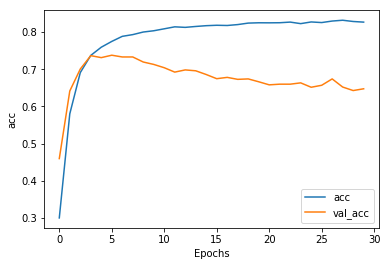

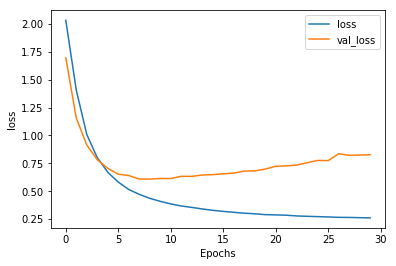

In [20]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

In [21]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [23]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 64)


In [24]:
def save_vecs_meta(reverse_word_index, vocab_size, weights):
    out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
    out_m = io.open('meta.tsv', 'w', encoding='utf-8')
    
    for word_num in range(1, vocab_size):
        word = reverse_word_index[word_num]
        embeddings = weights[word_num]
        out_m.write(word + "\n")
        out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
    out_v.close()
    out_m.close()

In [25]:
save_vecs_meta(reverse_word_index, vocab_size, weights)